<style>
.md-grid {
    max-width: 100%;
    /* add 5% padding left and right*/
    padding: 0 5%;
}
</style>

# Getting Started

In [1]:
import ciclo

Import MNIST using TensorFlow Datasets

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

batch_size = 32

ds_train: tf.data.Dataset = tfds.load("mnist", split="train", shuffle_files=True)
ds_train = ds_train.repeat().shuffle(1024).batch(batch_size).prefetch(1)

Define model architecture and a `create_state` function to initialize the model's weights and optimizer.

In [3]:
import jax
import jax.numpy as jnp
import optax
from flax.training.train_state import TrainState
import flax.linen as nn

class Linear(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = x / 255.0
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=10)(x)
        return x

def create_state():
    model = Linear()
    variables = model.init(jax.random.PRNGKey(0), jnp.empty((1, 28, 28, 1)))
    return TrainState.create(
        apply_fn=model.apply,
        params=variables["params"],
        tx=optax.adamw(1e-3),
    )

Create a `train_step` function that takes a batch of data and updates the model's weights. Use Ciclo's `log` helper to log metrics.

In [14]:
@jax.jit
def train_step(state: TrainState, batch):
    inputs, labels = batch["image"], batch["label"]

    def loss_fn(params):
        logits = state.apply_fn({"params": params}, inputs)
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=labels
        ).mean()
        return loss, logits

    (loss, logits), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    # log metrics
    logs = ciclo.logs()
    logs.add_metric("loss", loss)
    logs.add_metric("accuracy", jnp.mean(jnp.argmax(logits, -1) == labels))

    return logs, state

Create a training loop using `ciclo` utilities such as:

* `every`: a simple periodic `Schedule` that determines when run a task
* `checkpoint`: a `Callback` that saves the model's weights
* `keras_bar`: a `Callback` that displays a progress bar using log information
* `at`: a `Period` that determines when a certain amount of steps/samples/time has passed
* `logs`: a custom `Dict[str, Dict[str, Any]]` that contains helper methods to log values and merge information from multiple callbacks
* `history`: a custom `List[Logs]` that stores the logs from each iteration of the loop, contains helper methods to commit logs and collect values.
* `elapse`: a generator that yields an `(elapsed, batch)` tuple for each batch in the dataset. `Elapsed` is a pytree structure that contains information about the current iteration of the loop, number of samples seen, and amount of time passed since the start of the loop.

In [5]:
from time import time

total_steps = 5_000
call_checkpoint = ciclo.every(steps=1000)                              # schedule
checkpoint = ciclo.checkpoint(f"logdir/getting_started/{int(time())}") # callback
keras_bar = ciclo.keras_bar(total=total_steps, interval=0.4)           # callback
end_period = ciclo.at(total_steps)                                     # period

state = create_state() # initial state
history = ciclo.history() # logs history
for elapsed, batch in ciclo.elapse(ds_train.as_numpy_iterator()):
    logs = ciclo.logs() # logs: Dict[str, Dict[str, Any]]
    # update logs and state
    logs.updates, state = train_step(state, batch)
    # periodically checkpoint state
    if call_checkpoint(elapsed):
        checkpoint(elapsed, state) # save state

    keras_bar(elapsed, logs) # update progress bar
    history.commit(elapsed, logs) # commit logs to history
    # stop training when total_steps is reached
    if elapsed >= end_period:
        break

5000/5000 [==============================] - 11s 2ms/step - accuracy: 0.9029 - loss: 0.3610


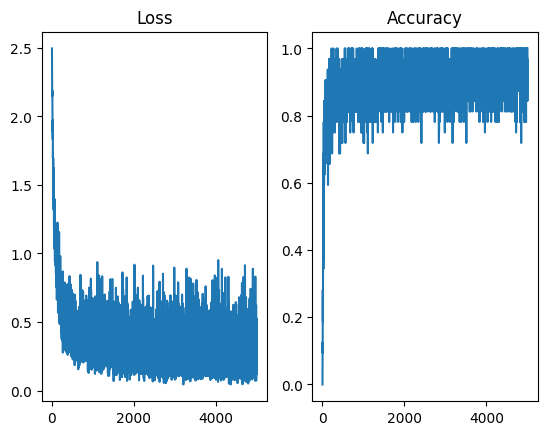

In [6]:
import matplotlib.pyplot as plt

# collect metric values
steps, loss, accuracy = history.collect("steps", "loss", "accuracy")

def plot_metrics(steps, loss, accuracy):
    fig, axs = plt.subplots(1, 2)
    axs[0].plot(steps, loss)
    axs[0].set_title("Loss")
    axs[1].plot(steps, accuracy)
    axs[1].set_title("Accuracy")
    plt.show()

plot_metrics(steps, loss, accuracy)

### Using Loop

Loop's signature is:

```python
def loop(
    state: State,
    dataset: Iterable[Batch],
    tasks: {Schedule: [Callback]},
) -> (State, History, Elapsed)
```

The `tasks` argument lets you express when to run different sets of callbacks (and in what order) in a very compact way.

5000/5000 [==============================] - 7s 1ms/step - accuracy: 0.9026 - loss: 0.3613


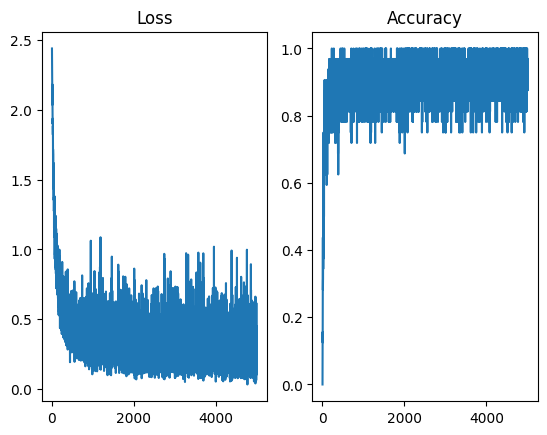

In [7]:
total_steps = 5_000
state = create_state()

state, history, elapsed = ciclo.loop(
    state,
    ds_train.as_numpy_iterator(),
    {
        ciclo.every(1): [train_step],
        ciclo.every(steps=1000): [
            ciclo.checkpoint(f"logdir/getting_started/{int(time())}")
        ],
        ciclo.every(1): [ciclo.keras_bar(total=total_steps, interval=0.4)],
    },
    stop=total_steps,
)

steps, loss, accuracy = history.collect("steps", "loss", "accuracy")
plot_metrics(steps, loss, accuracy)

#### Syntactic Sugar

If you have a single callback for a given schedule you can pass it directly. Furthermore, for `CallbackBase` instances (all callbacks in Ciclo implement this) that need to be run at every iteration, you can avoid having to specify the schedule by using the Mapping expansion `'**'` operator.

<!-- Create a table in markdown with 2 columns -->

| Syntax | Expansion |
| --- | --- |
| `schedule: callback` | `schedule: [callback]` |
| `**callback` | `every(1): [callback]` |



In [ ]:
total_steps = 5_000
state = create_state()

state, history, elapsed = ciclo.loop(
    state,
    ds_train.as_numpy_iterator(),
    {
        ciclo.every(1): train_step,
        ciclo.every(steps=1000): ciclo.checkpoint(
            f"logdir/getting_started/{int(time())}"
        ),
        **ciclo.keras_bar(total=total_steps, interval=0.4),
    },
    stop=total_steps,
)

steps, loss, accuracy = history.collect("steps", "loss", "accuracy")
plot_metrics(steps, loss, accuracy)